# 📑 &nbsp; Deep Learning. Breed Recognition
<a href="https://olgabelitskaya.github.io/README.html">&#x1F300; &nbsp; 
Home Page &nbsp;</a> &nbsp; &nbsp; &nbsp;
<a href="https://www.instagram.com/olga.belitskaya/">&#x1F300; &nbsp;
Instagram Posts &nbsp;</a> &nbsp; &nbsp; &nbsp;
<a href="https://www.pinterest.ru/olga_belitskaya/code-style/">&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have created the dataset of 
about 500 color images (160x160x3) with horse breeds.<br/>
## ✒️ &nbsp; Importing Libraries and Defining Helpful Functions

In [90]:
!pip install --upgrade neural_structured_learning \
--user --quiet --no-warn-script-location

In [91]:
sys_path='/root/.local/lib/python3.6/site-packages'
import sys; sys.path.append(sys_path)
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,torch,os
import tensorflow as tf,tensorflow_hub as th
import pandas as pd,numpy as np,pylab as pl,sympy as sp
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
import neural_structured_learning as nsl
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf,torch.nn as tnn
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
from IPython.core.display import display,HTML
from IPython.core.magic import register_line_magic

 ## ✒️ &nbsp; Data Loading and Preprocessing

In [92]:
file_path='https://raw.githubusercontent.com/OlgaBelitskaya/data_kitchen/main/'
file_name='HorseBreeds160.h5'; img_size=int(160)
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file(file_path,file_name)
with h5py.File(file_name,'r') as f:
    keys=list(f.keys())
    sp.pretty_print(
        'file keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    images=tf.image.resize(images,[img_size,img_size]).numpy()
    labels=np.array(f[keys[1]])
    names=[el.decode('utf-8')for el in f[keys[2]]]
    f.close()


file keys: images, labels, names


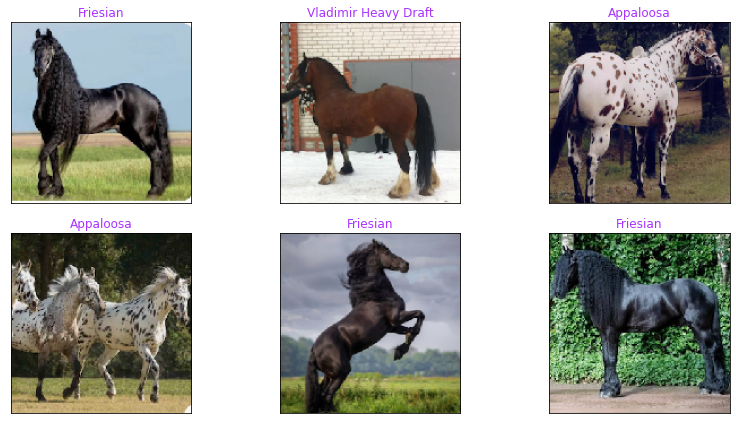

,train,valid,test
image shape,"(451, 160, 160, 3)","(56, 160, 160, 3)","(56, 160, 160, 3)"
image type,float32,float32,float32
label shape,"(451,)","(56,)","(56,)"
label type,int32,int32,int32


In [93]:
N=labels.shape[0]; n=int(.1*N)
num_classes=len(names); start=int(100) 
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
def display_imgs(images,labels,names,start):
    fig=pl.figure(figsize=(12,6)); n=np.random.randint(0,start-1)
    for i in range(n,n+6):
        ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='#aa33ff',
            fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names,start); display(df)

In [94]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
batch_size2=int(8); img_size2=int(64)
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=tf.image.resize(x_train,[img_size2,img_size2])
x_train2=np.transpose(x_train2.numpy(),(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=tf.image.resize(x_valid,[img_size2,img_size2])
x_valid2=np.transpose(x_valid2.numpy(),(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=tf.image.resize(x_test,[img_size2,img_size2])
x_test2=np.transpose(x_test2.numpy(),(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,batch_size=batch_size2)}

0.49648026 0.26926866


Image dimensions: torch.Size([8, 3, 64, 64])
Label dimensions: torch.Size([8])


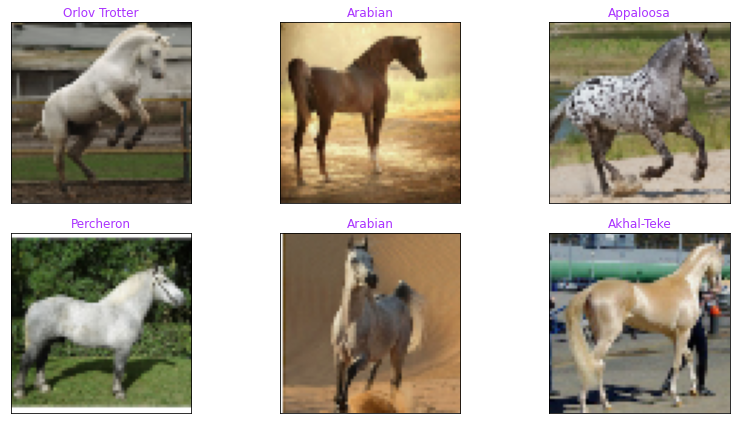

In [95]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,int(2))
        break
%display_data_imgs valid

## ✒️ &nbsp; Classification Models
### TFHub

In [96]:
def keras_history_plot(fit_history,fig_size=12,color='#aa33ff'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size//2))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[int(0),int(2)]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[int(1),int(3)]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [97]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model

In [98]:
handle_base='mobilenet_v2_100_160'
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [99]:
fw='/tmp/checkpoint'
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=int(0),save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
kmodel=premodel(img_size,2048,mhandle,num_classes,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=16,epochs=50,
                   callbacks=[checkpointer,early_stopping,lr_reduction],
                   validation_data=(x_valid,y_valid))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              2052096   
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 14343     
Total params: 5,606,704
Trainable params: 5,572,592
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
29/29 [==============================] - 7s 85ms/step - loss: 2.4687 - accuracy: 0.4647 - val_loss: 7.1410 - val_accuracy: 0.4643
Epoch 2/50
29/29 [==============================] - 2s 62ms/step - loss: 1.5996 - accuracy: 0.6524 - val_loss: 4.0201 - val_accuracy: 0.5893
Epoch 3/50
29/29 [==============================] - 2s 62ms/step - loss: 1.1571 - accuracy: 0.7653 - val_loss: 6.7256 - val_accuracy: 0.4286
Epoch 4/50
29/29 [==============================] - 2s 62ms/step - loss: 0.8972 - accuracy: 0.7836 - val_loss: 1.9154 - val_accuracy: 0.6429
Epoch 5/50
29/29 [==============================] - 2s 62ms/step - loss: 1.0037 - accuracy: 0.7789 - val_loss: 2.9804 - val_accuracy: 0.5536
Epoch 6/50
29/29 [==============================] - 2s 64ms/step - loss: 0.5955 - accuracy: 0.8725 - val_loss: 5.7627 - val_accuracy: 0.5536
Epoch 7/50
29/29 [==============================] - 2s 62ms/step - loss: 0.7233 - accuracy: 0.8908 - val_loss: 3.8321 - val_accuracy: 0.5893
Epoch 8/50
29

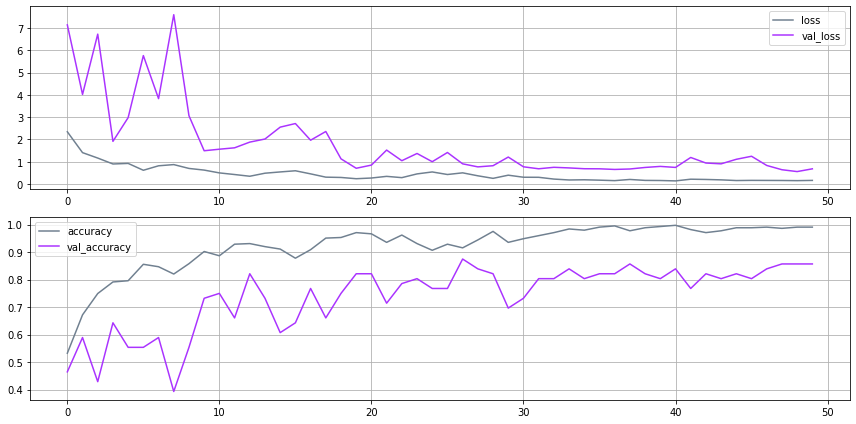

In [100]:
keras_history_plot(history)

In [101]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=int(0)))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

[1.5717087984085083, 0.6607142686843872]


In [102]:
y_test_predict,y_test

(array([0, 4, 6, 2, 3, 0, 2, 5, 4, 2, 1, 3, 0, 2, 6, 1, 0, 2, 2, 2, 2, 0,
        2, 0, 2, 2, 0, 1, 4, 1, 6, 3, 0, 1, 6, 6, 0, 2, 0, 0, 2, 0, 5, 5,
        2, 5, 2, 0, 0, 2, 2, 2, 6, 4, 3, 0]),
 array([0, 2, 5, 4, 3, 3, 5, 5, 2, 2, 1, 4, 0, 2, 6, 1, 2, 2, 4, 5, 2, 0,
        2, 4, 2, 5, 2, 1, 4, 1, 6, 3, 0, 1, 3, 3, 0, 4, 0, 0, 2, 0, 5, 5,
        3, 5, 2, 0, 0, 4, 2, 3, 6, 4, 3, 0], dtype=int32))

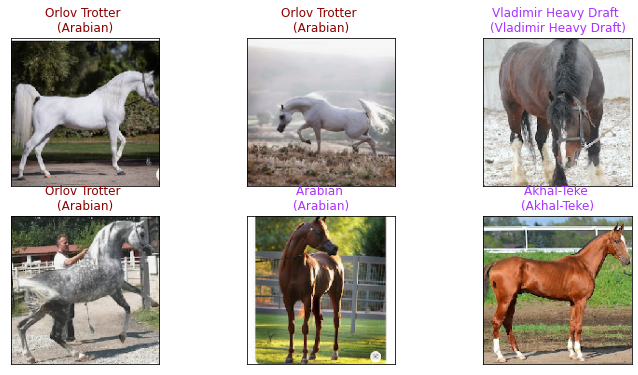

In [103]:
fig=pl.figure(figsize=(12,6))
randch=np.random.choice(
    x_test.shape[0],size=6,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title('{} \n({})'.format(
        names[pred_idx],names[true_idx]),
        color=('#aa33ff' if pred_idx==true_idx else 'darkred'))
pl.show()

In [104]:
def kmodel(leaky_alpha,num_classes=num_classes):
    model=tf.keras.Sequential()
    model.add(tkl.Conv2D(
        int(32),(int(5),int(5)),padding='same', 
        input_shape=x_train.shape[int(1):]))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(int(2),int(2))))
    model.add(tkl.Dropout(float(.25)))
    model.add(tkl.Conv2D(int(196),(int(5),int(5))))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(int(2),int(2))))
    model.add(tkl.Dropout(float(.25)))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(int(1024)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(float(.5)))     
    model.add(tkl.Dense(num_classes))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(float(.01))

In [105]:
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=int(20),verbose=int(2))
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=int(0),save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=int(2),
    patience=int(5),factor=float(.8))
history=kmodel.fit(x_train,y_train,epochs=int(70),
                   batch_size=int(16),verbose=int(2),
                   validation_data=(x_valid,y_valid),
                   callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/70
29/29 - 2s - loss: 1.8959 - accuracy: 0.1907 - val_loss: 1.9067 - val_accuracy: 0.2143
Epoch 2/70
29/29 - 1s - loss: 1.8723 - accuracy: 0.2040 - val_loss: 1.9834 - val_accuracy: 0.1071
Epoch 3/70
29/29 - 1s - loss: 1.8415 - accuracy: 0.2328 - val_loss: 1.8393 - val_accuracy: 0.2143
Epoch 4/70
29/29 - 1s - loss: 1.7504 - accuracy: 0.2838 - val_loss: 1.8145 - val_accuracy: 0.2321
Epoch 5/70
29/29 - 1s - loss: 1.6878 - accuracy: 0.3548 - val_loss: 1.7420 - val_accuracy: 0.3571
Epoch 6/70
29/29 - 1s - loss: 1.5960 - accuracy: 0.3792 - val_loss: 1.7773 - val_accuracy: 0.2321
Epoch 7/70
29/29 - 1s - loss: 1.5370 - accuracy: 0.3769 - val_loss: 1.5675 - val_accuracy: 0.3393
Epoch 8/70
29/29 - 1s - loss: 1.3776 - accuracy: 0.4568 - val_loss: 1.7672 - val_accuracy: 0.2857
Epoch 9/70
29/29 - 1s - loss: 1.2876 - accuracy: 0.5144 - val_loss: 1.8700 - val_accuracy: 0.3036
Epoch 10/70
29/29 - 1s - loss: 1.2491 - accuracy: 0.5011 - val_loss: 1.6192 - val_accuracy: 0.3571
Epoch 11/70
29/29 -

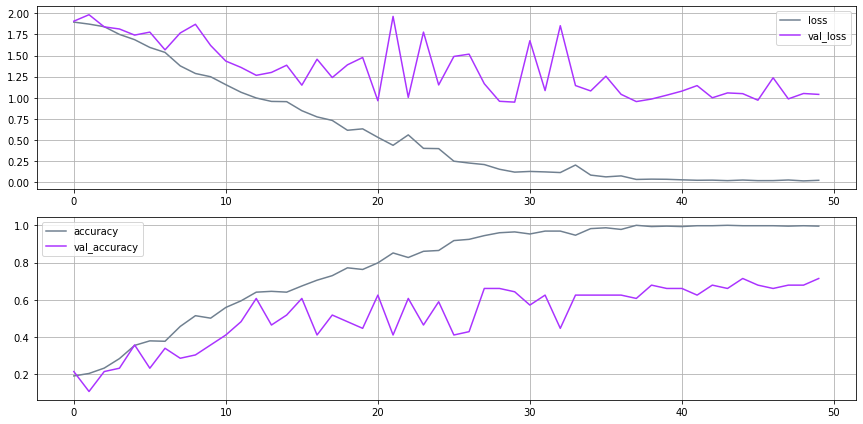

In [106]:
keras_history_plot(history)

In [107]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=int(0)))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

[1.6328985691070557, 0.5]


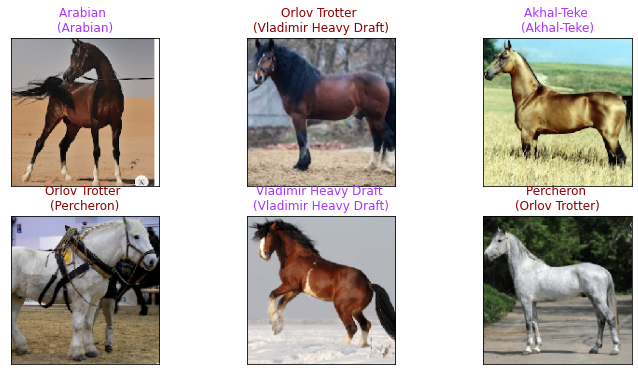

In [108]:
fig=pl.figure(figsize=(12,6))
randch=np.random.choice(x_test.shape[0],size=6,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title('{} \n({})'.format(names[pred_idx],names[true_idx]),
                 color=('#aa33ff' if pred_idx==true_idx else 'darkred'))
pl.show()

### PyTorch Models

In [123]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [124]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [125]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            str1='epoch: %03d/%03d | batch: %03d/%03d | cost: %.4f'
            if not batch_ids%10:
                sp.pretty_print(str1%(epoch+1,epochs,batch_ids,
                                      len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            sp.pretty_print('epoch: %03d/%03d'%(epoch+1,epochs))
            str2='train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'
            sp.pretty_print(str2%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [126]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [127]:
%train_run 15

epoch: 001/015 | batch: 000/056 | cost: 2.0110
epoch: 001/015 | batch: 010/056 | cost: 0.9305
epoch: 001/015 | batch: 020/056 | cost: 1.2961
epoch: 001/015 | batch: 030/056 | cost: 1.2632
epoch: 001/015 | batch: 040/056 | cost: 2.7525
epoch: 001/015 | batch: 050/056 | cost: 1.5072
epoch: 001/015
train acc/loss: 66.74%/1.02 valid acc/loss: 58.93%/1.06
epoch: 002/015 | batch: 000/056 | cost: 0.6162
epoch: 002/015 | batch: 010/056 | cost: 2.2266
epoch: 002/015 | batch: 020/056 | cost: 1.6664
epoch: 002/015 | batch: 030/056 | cost: 1.4631
epoch: 002/015 | batch: 040/056 | cost: 1.2820
epoch: 002/015 | batch: 050/056 | cost: 1.4471
epoch: 002/015
train acc/loss: 69.42%/0.90 valid acc/loss: 48.21%/1.23
epoch: 003/015 | batch: 000/056 | cost: 1.3291
epoch: 003/015 | batch: 010/056 | cost: 0.7518
epoch: 003/015 | batch: 020/056 | cost: 1.5150
epoch: 003/015 | batch: 030/056 | cost: 1.2181
epoch: 003/015 | batch: 040/056 | cost: 1.5587
epoch: 003/015 | batch: 050/056 | cost: 1.8851
epoch: 003/0

In [128]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% | test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 94.42% | test acc: 57.14%


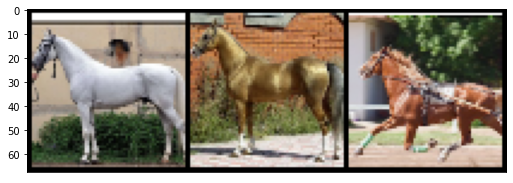


true labels:         Orlov Trotter          Akhal-Teke       Orlov Trotter

predictions:               Arabian          Akhal-Teke           Appaloosa


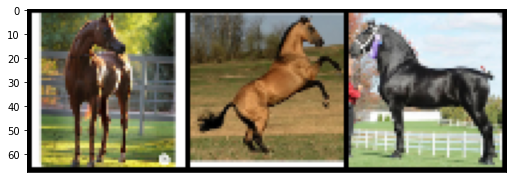


true labels:               Arabian          Akhal-Teke           Percheron

predictions:            Akhal-Teke          Akhal-Teke          Akhal-Teke


In [129]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(12,3))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:3]))
        print('\ntrue labels: ',
              ''.join('%20s'%names[labels[j]] for j in range(3)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,int(1))
        print('\npredictions: ',
             ''.join('%20s'%names[preds[j]] for j in range(3)))
        if i==1: break